In [1]:
import sys
sys.path.append('../')

import numpy as np
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from framework.mtl_model import MTLModel
from framework.trainer import Trainer
from data.dataloader.taskonomy_dataloader import Taskonomy
from data.heads.pixel2pixel import ASPPHeadNode
from data.metrics.pixel2pixel_loss import TaskonomyCriterions
from data.metrics.pixel2pixel_metrics import TaskonomyMetrics

In [2]:
dataroot = '/work/lijunzhang_umass_edu/data/policymtl/data/Taskonomy/'
tasks = ['segment_semantic', 'normal', 'depth_zbuffer', 'keypoints2d', 'edge_texture']
task_cls_num = {'segment_semantic': 17, 'normal': 3, 'depth_zbuffer': 1, 'keypoints2d': 1, 'edge_texture': 1}

headsDict = nn.ModuleDict()
trainDataloaderDict = {task: [] for task in tasks}
valDataloaderDict = {}
criterionDict = {}
metricDict = {}

for task in tasks:
    headsDict[task] = ASPPHeadNode(512, task_cls_num[task])

    # For model trainer
    dataset = Taskonomy(dataroot, 'train', task, crop_h=224, crop_w=224)
    trainDataloaderDict[task].append(DataLoader(dataset, batch_size=16, shuffle=True))
    dataset1 = Taskonomy(dataroot, 'train1', task, crop_h=224, crop_w=224)
    trainDataloaderDict[task].append(DataLoader(dataset1, 16, shuffle=True)) # for network param training
    dataset2 = Taskonomy(dataroot, 'train2', task, crop_h=224, crop_w=224) 
    trainDataloaderDict[task].append(DataLoader(dataset2, 16, shuffle=True)) # for policy param training

    dataset = Taskonomy(dataroot, 'test_small', task, crop_h=224, crop_w=224)
    valDataloaderDict[task] = DataLoader(dataset, batch_size=8, shuffle=True)

    criterionDict[task] = TaskonomyCriterions(task, dataroot)
    metricDict[task] = TaskonomyMetrics(task, dataroot)

In [3]:
prototxt = '../models/deeplab_resnet34_adashare.prototxt'
mtlmodel = MTLModel(prototxt, headsDict, BNsp=True)
mtlmodel = mtlmodel.cuda()

In [4]:
checkpoint = '/work/lijunzhang/data/policymtl/checkpoint/'
trainer = Trainer(mtlmodel, trainDataloaderDict, valDataloaderDict, criterionDict, metricDict, 
                  print_iters=100, val_iters=500, save_num=1, policy_update_iters=100)

In [4]:
import time
trainer = Trainer(mtlmodel, trainDataloaderDict, valDataloaderDict, criterionDict, metricDict, 
                  print_iters=100, val_iters=10000, save_num=1, policy_update_iters=100)
start = time.time()
trainer.pre_train(iters=1000, lr=0.0001)
print(time.time()-start)

[Iter 100 Task segm] Train Loss: 1.5779
[Iter 100 Task norm] Train Loss: 0.3373
[Iter 100 Task dept] Train Loss: 0.2571
[Iter 100 Task keyp] Train Loss: 0.3688
[Iter 100 Task edge] Train Loss: 0.4154
[Iter 100 Total] Train Loss: 0.5913
[Iter 200 Task segm] Train Loss: 1.6064
[Iter 200 Task norm] Train Loss: 0.3049
[Iter 200 Task dept] Train Loss: 0.0826
[Iter 200 Task keyp] Train Loss: 0.2308
[Iter 200 Task edge] Train Loss: 0.2471
[Iter 200 Total] Train Loss: 0.4944
[Iter 300 Task segm] Train Loss: 1.4478
[Iter 300 Task norm] Train Loss: 0.2949
[Iter 300 Task dept] Train Loss: 0.0576
[Iter 300 Task keyp] Train Loss: 0.1914
[Iter 300 Task edge] Train Loss: 0.2135
[Iter 300 Total] Train Loss: 0.4410
[Iter 400 Task segm] Train Loss: 1.4639
[Iter 400 Task norm] Train Loss: 0.2898
[Iter 400 Task dept] Train Loss: 0.0503
[Iter 400 Task keyp] Train Loss: 0.1752
[Iter 400 Task edge] Train Loss: 0.1930
[Iter 400 Total] Train Loss: 0.4344
[Iter 500 Task segm] Train Loss: 1.4411
[Iter 500 Task n

In [5]:
trainer.pre_train(iters=10000, lr=0.001, savePath=checkpoint+'Taskonomy/')

[Iter 50 Task segm] Train Loss: 3.8457
[Iter 50 Task norm] Train Loss: 0.0871
[Iter 50 Task dept] Train Loss: 3.2112
[Iter 50 Total] Train Loss: 2.3813
[Iter 100 Task segm] Train Loss: 2.9756
[Iter 100 Task norm] Train Loss: 0.0680
[Iter 100 Task dept] Train Loss: 1.3305
[Iter 100 Total] Train Loss: 1.4580
[Iter 150 Task segm] Train Loss: 2.8945
[Iter 150 Task norm] Train Loss: 0.0690
[Iter 150 Task dept] Train Loss: 1.2017
[Iter 150 Total] Train Loss: 1.3884
[Iter 200 Task segm] Train Loss: 2.8681
[Iter 200 Task norm] Train Loss: 0.0692
[Iter 200 Task dept] Train Loss: 1.5088
[Iter 200 Total] Train Loss: 1.4820
[Iter 200 Task segm] Val Loss: 2.8249
{'mIoU': 0.1108, 'Pixel Acc': 0.3051, 'cmp': -0.5395}
[Iter 200 Task norm] Val Loss: 0.0703
{'Angle Mean': 19.1806, 'Angle Median': 16.469, 'Angle 11.25': 19.9282, 'Angle 22.5': 71.4832, 'Angle 30': 86.8832, 'cmp': -0.1392}
[Iter 200 Task dept] Val Loss: 1.0561
{'abs_err': 1.0501, 'rel_err': 0.4232, 'sigma_1.25': 35.536, 'sigma_1.25^2': 64.

In [ ]:
loss_lambda = {'segment_semantic': 1, 'normal':3, 'depth_zbuffer': 2, 'keypoints2d':7, 'edge_texture':7, 'policy':0.0005}
trainer.alter_train_with_reg(iters=50000, policy_network_iters=(100,400), policy_lr=0.01, network_lr=0.0001, 
                             loss_lambda=loss_lambda,
                             savePath=checkpoint+'Taskonomy/', reload='alter_train_with_reg_0005_20000iter.model')

[Iter 20100 Task segm] Task Loss: 1.2413 Reg Loss: 34.2871 Train Loss: 1.2584
[Iter 20100 Task norm] Task Loss: 0.2926 Reg Loss: 34.5928 Train Loss: 0.8951
[Iter 20100 Task dept] Task Loss: 0.0416 Reg Loss: 35.9328 Train Loss: 0.1012
[Iter 20100 Task keyp] Task Loss: 0.1668 Reg Loss: 34.8966 Train Loss: 1.1851
[Iter 20100 Task edge] Task Loss: 0.1790 Reg Loss: 33.8931 Train Loss: 1.2697
[Iter 20100 Total] Train Loss: 0.9419
[Iter 20200 Task segm] Task Loss: 1.2495 Reg Loss: 23.5818 Train Loss: 1.2613
[Iter 20200 Task norm] Task Loss: 0.2922 Reg Loss: 23.7873 Train Loss: 0.8884
[Iter 20200 Task dept] Task Loss: 0.0415 Reg Loss: 24.0056 Train Loss: 0.0951
[Iter 20200 Task keyp] Task Loss: 0.1684 Reg Loss: 23.7445 Train Loss: 1.1909
[Iter 20200 Task edge] Task Loss: 0.1785 Reg Loss: 23.6641 Train Loss: 1.2610
[Iter 20200 Total] Train Loss: 0.9393
[Iter 20300 Task segm] Task Loss: 1.2683 Reg Loss: 23.4896 Train Loss: 1.2801
[Iter 20300 Task norm] Task Loss: 0.2923 Reg Loss: 23.8005 Train L

In [ ]:
# random_policy_with_bottom10_shared_seed98.model
loss_lambda = {'segment_semantic': 1, 'normal':3, 'depth_zbuffer': 2, 'keypoints2d':7, 'edge_texture':7}
trainer.post_train(iters=30000, lr=0.001, 
                   loss_lambda=loss_lambda,
                   decay_lr_freq=4000, decay_lr_rate=0.5,
                   savePath=checkpoint+'Taskonomy/', reload='post_train_11400iter.model')

[Iter 11500 Task segm] Train Loss: 0.8184
[Iter 11500 Task norm] Train Loss: 0.4855
[Iter 11500 Task dept] Train Loss: 0.0610
[Iter 11500 Task keyp] Train Loss: 0.6680
[Iter 11500 Task edge] Train Loss: 0.6199
[Iter 11500 Total] Train Loss: 0.5306
[Iter 11500 Task segm] Val Loss: 0.8376
{'err': 0.8644, 'cmp': -0.5032}
[Iter 11500 Task norm] Val Loss: 0.1405
{'cosine_similarity': 0.8424, 'cmp': 0.1916}
[Iter 11500 Task dept] Val Loss: 0.0338
{'abs_err': 0.034, 'cmp': -0.5454}
[Iter 11500 Task keyp] Val Loss: 0.1005
{'err': 0.2043, 'cmp': -0.037}
[Iter 11500 Task edge] Val Loss: 0.1046
{'err': 0.2054, 'cmp': 0.031}
[Iter 11600 Task segm] Train Loss: 0.8477
[Iter 11600 Task norm] Train Loss: 0.4879
[Iter 11600 Task dept] Train Loss: 0.0613
[Iter 11600 Task keyp] Train Loss: 0.6579
[Iter 11600 Task edge] Train Loss: 0.6300
[Iter 11600 Total] Train Loss: 0.5370
[Iter 11700 Task segm] Train Loss: 0.8330
[Iter 11700 Task norm] Train Loss: 0.4813
[Iter 11700 Task dept] Train Loss: 0.0623
[Iter

In [4]:
mtlmodel.net

ModuleList(
  (0): Conv2dNode(
    (taskOp): ModuleDict(
      (segment_semantic): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (depth_zbuffer): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    )
    (dsOp): ModuleDict(
      (segment_semantic): ModuleList(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): AvgPool2d(kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      )
      (depth_zbuffer): ModuleList(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): AvgPool2d(kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      )
    )
    (policy): ParameterDict(
        (segment_semantic): Parameter containing: [torch.cuda.FloatTensor of size 3 (GPU 0)]
        (depth_zbuffer): Parameter containing: [torch.cuda.FloatTensor of size 3 (GPU 0)]
    )
    (basicOp): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (1): BN2dNode(
    (taskOp)

# Policy layer-wise training

In [4]:
class Trainer2(Trainer):
    def __init__(self, model, train_dataloader_dict, val_dataloader_dict, criterion_dict, metric_dict, 
                 print_iters=50, val_iters=2000, save_iters=200, policy_update_iters=100, next_policy_iters=200):
        super(Trainer2, self).__init__(model, train_dataloader_dict, val_dataloader_dict, criterion_dict, metric_dict, 
                 print_iters, val_iters, save_iters, policy_update_iters)
        self.next_policy_iters = next_policy_iters
        
    def layerwise_policy_train(self, iters, task_iters=None, policy_lr=0.01, network_lr=0.0001, 
                               start_tau=5, tau_ratio=0.965,
                               policy_scale=6, loss_lambda=1.0,
                               writerPath=None, savePath=None, reload=None):
        self.model.train()
        if writerPath != None:
            writer = SummaryWriter(log_dir=writerPath+'layerwise_policy_train/')
        else:
            writer = None
        
        start = 0
        policy_idx = self.model.next_policy_idx(-1)
        tau = start_tau
        if reload is not None and savePath is not None:
            state = torch.load(savePath + reload)
            self.model.load_state_dict(state['state_dict'])
            if 'layerwise_policy_train' in reload:
#                 optimizer.load_state_dict(state['optimizer'])
                start = state['iter'] + 1 
                policy_idx = state['policy_idx']
                tau = state['tau']
        
        # Step 1: Set optimizer
        self.freeze_policy()
        optimizer = torch.optim.SGD([{'params': filter(lambda p: p.requires_grad==False, self.model.parameters()), 'lr': policy_lr},
                            {'params': filter(lambda p: p.requires_grad, self.model.parameters()), 'lr': network_lr}],
                                    momentum=0.9, weight_decay=1e-4)
        self.unfreeze_policy_so_far(policy_idx) # For Adashare-layerwise
        
        # Step 2: Set task training iters
        if task_iters is None or len(task_iters) != len(self.tasks):
            task_iters = tuple([100] * len(self.tasks))
        
        for i in range(start, iters):
            # Step 3: Check whether to train the next policy 
#             if tau < 1e-2: # For fixed-layerwise
            if (i+1) % self.next_policy_iters == 0 and policy_idx < self.model.max_policy_idx(): # For Adashare-layerwise
                # Fixed the current policy parameters # For fixed-layerwise
#                 self.freeze_layerwise_policy(policy_idx) 
#                 print('current policy:')
#                 for task in self.tasks:
#                     print('task: ' + task)
#                     print(self.model.current_policy(policy_idx,task))

                # Go to the next policy idx
                policy_idx = self.model.next_policy_idx(policy_idx)
                print('[iter ' + str(i+1) + '] policy_idx change to: ' + str(policy_idx))
            
                # Unfreeze the next policy # For Adashare-layerwise
                self.unfreeze_layerwise_policy(policy_idx) 
                
                # Reset tau # For fixed-layerwise
#                 tau = start_tau 
            
            # Step 4: Train network and policy jointly
            #         Train tasks alternatively
            task_idx = self.which_task(i, task_iters)
            self.train_step_task_with_reg('layerwise_policy_train', self.tasks[task_idx], optimizer,tau=tau, 
                                          policy_idx=policy_idx, scale=policy_scale, loss_lambda=loss_lambda)

            # Step 5: Update tau in policy every self.policy_update_iters
            #         If reach the end of the model, don't update anymore
#             if (i+1) % self.policy_update_iters == 0 and policy_idx < self.model.max_policy_idx(): # For fixed-layerwise
            if (i+1) % self.policy_update_iters == 0 and tau > 1e-6: # For Adashare-layerwise
                tau = tau * tau_ratio
                print('tau: ' + str(tau))
                count = 0
                for name, param in self.model.named_parameters():
                    if 'policy' in name and count < 16 and not self.model.net[int(name.split('.')[1])].assumeSp:
                        print(name, param)
                        count += 1

            # Step 6: Print loss
            if (i+1) % self.print_iters == 0:
                self.print_train_loss_with_reg(i, writer)
                self.reset_train_loss()
            
            # Step 7: Validation
            if (i+1) % self.val_iters == 0:
                self.validate('layerwise_policy_train', i, tau=tau, hard=False, writer=writer, policy_idx=policy_idx)
                self.model.train()
                
            # Step 8: Save model
            if (i+1) % self.save_iters == 0:
                if savePath is not None:
                    state = {'iter': i,
                            'state_dict': self.model.state_dict(),
                            'optimizer': optimizer.state_dict(),
                            'tau': tau,
                            'policy_idx': policy_idx}
                    self.save_model(state, 'layerwise_policy_train', savePath)
                    
        # Reset loss list and the data iters
        self.set_train_loss_data_iter()
        return
    
    def task_alter_train_with_reg(self, iters, task_iters=None, policy_lr=0.01, network_lr=0.0001, 
                                   tau=5, tau_ratio=0.965,
                                   policy_scale=6, loss_lambda=1.0, 
                                   writerPath=None, savePath=None, reload=None):
        self.model.train()
        if writerPath != None:
            writer = SummaryWriter(log_dir=writerPath+'task_alter_train/')
        else:
            writer = None
        
        # Step 1: Set optimizer
        self.freeze_policy()
        optimizer = torch.optim.SGD([{'params': filter(lambda p: p.requires_grad==False, self.model.parameters()), 'lr': policy_lr},
                                     {'params': filter(lambda p: p.requires_grad, self.model.parameters()), 'lr': network_lr}],
                                      momentum=0.9, weight_decay=1e-4)
        self.unfreeze_all_weights()
        
        start = 0
        if reload is not None and savePath is not None:
            state = torch.load(savePath + reload)
            self.model.load_state_dict(state['state_dict'])
            if 'task_alter_train' in reload:
#                 optimizer.load_state_dict(state['optimizer'])
                tau = state['tau']
                start = state['iter'] + 1 
        
        # Step 2: Set task training iters
        if task_iters is None or len(task_iters) != len(self.tasks):
            task_iters = tuple([100] * len(self.tasks))
        
        for i in range(start, iters):
            # Step 2-1: Train network and policy jointly
            task_idx = self.which_task(i, task_iters)
            self.train_step_task_with_reg('mtl', self.tasks[task_idx], optimizer, tau=tau, scale=policy_scale, loss_lambda=loss_lambda)

            # Step 3: Update tau in policy every self.policy_update_iters
            if (i+1) % self.policy_update_iters == 0 and tau > 1e-6:
                tau = tau * 0.965
                print('tau: ' + str(tau))
                count = 0
                for name, param in self.model.named_parameters():
                    if 'policy' in name and count < 16 and not self.model.net[int(name.split('.')[1])].assumeSp:
                        print(name, param)
                        count += 1

            # Step 4: Print loss
            if (i+1) % self.print_iters == 0:
                self.print_train_loss_with_reg(i, writer)
                self.reset_train_loss()
            
            # Step 5: Validation
            if (i+1) % self.val_iters == 0:
                self.validate('mtl', i, tau=tau, hard=True, writer=writer)
                self.model.train()
                
            # Step 6: Save model
            if (i+1) % self.save_iters == 0:
                if savePath is not None:
                    state = {'iter': i,
                            'state_dict': self.model.state_dict(),
                            'optimizer': optimizer.state_dict(),
                            'tau': tau}
                    self.save_model(state, 'task_alter_train', savePath)
                    
        # Reset loss list and the data iters
        self.set_train_loss_data_iter()
        return
    
    def alter_train_with_reg(self, iters, policy_network_iters=(100,400), policy_lr=0.01, network_lr=0.0001, 
                             tau=5, tau_ratio=0.965,
                             policy_scale=6, loss_lambda=1.0,
                             share_num=0,
                             writerPath=None, savePath=None, reload=None):
        self.model.train()
        # Key point: set two optimizers, one for the model, one for the policy
        if writerPath != None:
            writer = SummaryWriter(log_dir=writerPath+'alter_train_with_reg_bottom_' + str(share_num)+'/')
        else:
            writer = None
        
        # Step 1: Get the two optimizers for network and policy respectively
        self.freeze_policy()
        policy_op = torch.optim.Adam(filter(lambda p: p.requires_grad==False, self.model.parameters()), lr=policy_lr, weight_decay=5*1e-4)
        network_op = torch.optim.SGD(filter(lambda p: p.requires_grad, self.model.parameters()), lr=network_lr, momentum=0.9, weight_decay=1e-4)
        self.unfreeze_all_weights()
        start = 0
        if reload is not None and savePath is not None:
            state = torch.load(savePath + reload)
            self.model.load_state_dict(state['state_dict'])
            if 'alter_train_with_reg_bottom_' + str(share_num) in reload:
#                 policy_op.load_state_dict(state['policy_op'])
#                 network_op.load_state_dict(state['network_op'])
                tau = state['tau']
                start = state['iter'] + 1       
        
        # Share and freeze some bottom layers 
        self.freeze_and_share_bottom_policy(share_num)
        
        # Step 2: Train network and policy alternatively
        policy_count = 0
        for i in range(start, iters):
            # Step 2-1: Train policy when the current iter is in the first part of policy_network_iters
            if i % (policy_network_iters[0] + policy_network_iters[1]) in range(policy_network_iters[0]):
                self.train_step_with_reg('mtl', policy_op, tau=tau,loss_lambda=loss_lambda)
                policy_count += 1
            # Step 2-2: Train network when the current iter is in the second part of policy_network_iters
            else:
                self.train_step_with_reg('mtl', network_op, tau=tau, scale=policy_scale, loss_lambda=loss_lambda)

            # Step 3: Update tau in policy every self.policy_update_iters
            if policy_count > self.policy_update_iters and tau > 1e-6:
                tau = tau * tau_ratio
                print('tau: ' + str(tau))
                policy_count = 0

            # Step 4: Print loss
            if (i+1) % self.print_iters == 0:
                self.print_train_loss_with_reg(i, writer)
                self.reset_train_loss()
            
            # Step 5: Validation
            if (i+1) % self.val_iters == 0:
                self.validate('mtl', i, tau=tau, writer=writer)
                self.model.train()
                
            # Step 6: Save model
            if (i+1) % self.save_iters == 0:
                if savePath is not None:
                    state = {'iter': i,
                            'state_dict': self.model.state_dict(),
                            'policy_op': policy_op.state_dict(),
                            'network_op': network_op.state_dict(),
                            'tau': tau}
                    self.save_model(state, 'alter_train_with_reg_bottom_' + str(share_num), savePath)
                    
        # Reset loss list and the data iters
        self.set_train_loss_data_iter()
        return
    
    # Helper Functions
    def train_step_with_reg(self, stage, optimizer, schedular=None, 
                            tau=1, hard=False, 
                            policy_idx=None, scale=6, loss_lambda=1.0):
        # Function: Train one iter for each task 
        for task in self.tasks:
            try:
                data = next(self.train_iter_dict[task])
            except StopIteration:
                self.train_iter_dict[task] = iter(self.train_dataloader_dict[task])
                continue
            except:
                continue
                
            x = data['input'].cuda()
            y = data['label'].cuda()

            optimizer.zero_grad()
            output = self.model(x, stage, task, tau, hard, policy_idx)
            if 'mask' in data:
                tloss = self.criterion_dict[task](output, y, data['mask'].cuda())
            else:
                tloss = self.criterion_dict[task](output, y)
            
            regloss = self.model.policy_reg(task, policy_idx, tau, scale) # For fixed-layerwise or no layerwise
#             regloss = self.model.policy_reg_so_far(task, policy_idx, tau, scale) # For Adashare-layerwise
            if isinstance(loss_lambda, dict):
                loss = loss_lambda[task] * tloss + loss_lambda['policy'] * regloss
            elif isinstance(loss_lambda, float):
                loss = tloss + loss_lambda * regloss
            else:
                sys.exit('Loss weights (lambda) should be in the type of dictionary or float.')
            
            loss.backward()
            optimizer.step()
            self.loss_list[task].append((tloss.item(), regloss.item(), loss.item()))  
            
        if schedular is not None:
            scheduler.step()
        return
    
    def train_step_task_with_reg(self, stage, task, optimizer, schedular=None, 
                                 tau=1, hard=False, 
                                 policy_idx=None, scale=6, loss_lambda=1.0):
        # Function: Train one iter for one task 
        try:
            data = next(self.train_iter_dict[task])
        except StopIteration:
            self.train_iter_dict[task] = iter(self.train_dataloader_dict[task])
            return
        except:
            return

        x = data['input'].cuda()
        y = data['label'].cuda()

        optimizer.zero_grad()
        output = self.model(x, stage, task, tau, hard, policy_idx)
        if 'mask' in data:
            tloss = self.criterion_dict[task](output, y, data['mask'].cuda())
        else:
            tloss = self.criterion_dict[task](output, y)
        
        regloss = self.model.policy_reg(task, policy_idx, tau, scale) # For fixed-layerwise or no layerwise
#         regloss = self.model.policy_reg_so_far(task, policy_idx, tau, scale) # For Adashare-layerwise
        if isinstance(loss_lambda, dict):
            loss = loss_lambda[task] * tloss + loss_lambda['policy'] * regloss
        elif isinstance(loss_lambda, float):
            loss = tloss + loss_lambda * regloss
        else:
            sys.exit('Loss weights (lambda) should be in the type of dictionary or float.')
        loss.backward()
        optimizer.step()
        
        self.loss_list[task].append((tloss.item(), regloss.item(), loss.item()))  
            
        if schedular is not None:
            scheduler.step()
        return
    
    def print_train_loss_with_reg(self, it, writer=None):
        # Function: Print loss for each task
        total_loss = 0
        task_num = 0
        
        for task in self.tasks:
            if self.loss_list[task]:
                avg_tloss = np.mean([x[0] for x in self.loss_list[task]])
                avg_regloss = np.mean([x[1] for x in self.loss_list[task]])
                avg_loss = np.mean([x[2] for x in self.loss_list[task]])
            else:
                continue
            total_loss += avg_loss
            task_num += 1
            if writer != None:
                writer.add_scalar('Loss/train/' + task, avg_loss, it)
            print('[Iter {} Task {}] Task Loss: {:.4f} Reg Loss: {:.4f} Train Loss: {:.4f}'.format((it+1), task[:4], avg_tloss, avg_regloss, avg_loss), flush=True)
        print('[Iter {} Total] Train Loss: {:.4f}'.format((it+1), total_loss/task_num), flush=True)
        print('======================================================================', flush=True)
        return

In [5]:
trainer = Trainer2(mtlmodel, trainDataloaderDict, valDataloaderDict, criterionDict, metricDict, 
                   val_iters=200, print_iters=100, save_num=1, policy_update_iters=100)

In [ ]:
loss_lambda = {'segment_semantic': 1, 'normal':1, 'depth_zbuffer': 1, 'policy':0.001}
trainer.alter_train_with_reg(iters=20000, policy_network_iters=(50,50), policy_lr=0.01, network_lr=0.001, 
                                 tau=5, loss_lambda=loss_lambda, share_num=0,
                                 savePath='/mnt/nfs/work1/huiguan/lijunzhang/policymtl/checkpoint/NYUv2/', reload='pre_train_all_10000iter.model')

[Iter 100 Task segm] Task Loss: 1.9095 Reg Loss: 12.5538 Train Loss: 1.9108
[Iter 100 Task norm] Task Loss: 0.0693 Reg Loss: 12.5841 Train Loss: 0.0706
[Iter 100 Task dept] Task Loss: 0.9226 Reg Loss: 12.6524 Train Loss: 0.9238
[Iter 100 Total] Train Loss: 0.9684
[Iter 200 Task segm] Task Loss: 1.5541 Reg Loss: 12.3638 Train Loss: 1.5554
[Iter 200 Task norm] Task Loss: 0.0682 Reg Loss: 12.7040 Train Loss: 0.0695
[Iter 200 Task dept] Task Loss: 0.8463 Reg Loss: 12.8824 Train Loss: 0.8476
[Iter 200 Total] Train Loss: 0.8242
[Iter 200 Task segm] Val Loss: 1.8985
{'mIoU': 0.1438, 'Pixel Acc': 0.4666, 'cmp': -0.3425}
[Iter 200 Task norm] Val Loss: 0.0714
{'Angle Mean': 19.3852, 'Angle Median': 17.498, 'Angle 11.25': 20.5944, 'Angle 22.5': 70.3324, 'Angle 30': 86.7198, 'cmp': -0.1557}
[Iter 200 Task dept] Val Loss: 0.7808
{'abs_err': 0.7759, 'rel_err': 0.3274, 'sigma_1.25': 47.9156, 'sigma_1.25^2': 77.4812, 'sigma_1.25^3': 91.5769, 'cmp': -0.1747}
tau: 4.825
[Iter 300 Task segm] Task Loss: 1

In [6]:
trainer.post_train(iters=30000, task_iters=(50,50,50), lr=0.001, 
                   decay_lr_freq=4000, decay_lr_rate=0.5,
                   savePath='/mnt/nfs/work1/huiguan/lijunzhang/policymtl/checkpoint/NYUv2/', reload='alter_train_with_reg_bottom_0_20000iter.model')

Task Policy:
OrderedDict([('net.0.policy.segment_semantic', tensor([1., 0., 0.])), ('net.0.policy.depth_zbuffer', tensor([1., 0., 0.])), ('net.1.policy.segment_semantic', tensor([0., 0., 0.], device='cuda:0')), ('net.1.policy.depth_zbuffer', tensor([0., 0., 0.], device='cuda:0')), ('net.4.policy.segment_semantic', tensor([1., 0., 0.])), ('net.4.policy.depth_zbuffer', tensor([1., 0., 0.])), ('net.5.policy.segment_semantic', tensor([0., 0., 0.], device='cuda:0')), ('net.5.policy.depth_zbuffer', tensor([0., 0., 0.], device='cuda:0')), ('net.7.policy.segment_semantic', tensor([1., 0., 0.])), ('net.7.policy.depth_zbuffer', tensor([1., 0., 0.])), ('net.8.policy.segment_semantic', tensor([0., 0., 0.], device='cuda:0')), ('net.8.policy.depth_zbuffer', tensor([0., 0., 0.], device='cuda:0')), ('net.11.policy.segment_semantic', tensor([1., 0., 0.])), ('net.11.policy.depth_zbuffer', tensor([1., 0., 0.])), ('net.12.policy.segment_semantic', tensor([0., 0., 0.], device='cuda:0')), ('net.12.policy.de

In [6]:
loss_lambda = {'segment_semantic': 1, 'depth_zbuffer': 1, 'policy':0.0001}
trainer.task_alter_train_with_reg(iters=20000, task_iters=(100,100), policy_lr=0.01, network_lr=0.001, 
                                 tau=5, loss_lambda=loss_lambda,
                                 savePath='/mnt/nfs/work1/huiguan/lijunzhang/policymtl/checkpoint/Cityscapes-training/', reload='pre_train_all_10000iter.model')

tau: 4.825
net.0.policy.segment_semantic Parameter containing:
tensor([ 1.1447e-03, -1.1673e-03,  2.2609e-05], device='cuda:0',
       requires_grad=True)
net.0.policy.depth_zbuffer Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)
net.4.policy.segment_semantic Parameter containing:
tensor([ 0.0050,  0.0054, -0.0104], device='cuda:0', requires_grad=True)
net.4.policy.depth_zbuffer Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)
net.7.policy.segment_semantic Parameter containing:
tensor([ 0.0025,  0.0018, -0.0043], device='cuda:0', requires_grad=True)
net.7.policy.depth_zbuffer Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)
net.11.policy.segment_semantic Parameter containing:
tensor([ 0.0016,  0.0013, -0.0030], device='cuda:0', requires_grad=True)
net.11.policy.depth_zbuffer Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)
net.14.policy.segment_semantic Parameter

In [7]:
# Adashare style
loss_lambda = {'segment_semantic': 1, 'depth_zbuffer': 1, 'policy':0.00}
trainer.layerwise_policy_train(iters=20000, task_iters=(100,100), policy_lr=0.01, network_lr=0.001, 
                               tau_ratio=0.965, loss_lambda=loss_lambda,
                               savePath='/mnt/nfs/work1/huiguan/lijunzhang/policymtl/checkpoint/Cityscapes-training/', reload='layerwise_policy_train_12400iter.model')

tau: 0.05819479897319213
net.0.policy.segment_semantic Parameter containing:
tensor([ 1.5194,  1.3045, -2.8239], device='cuda:0', requires_grad=True)
net.0.policy.depth_zbuffer Parameter containing:
tensor([ 0.0889,  0.0811, -0.1700], device='cuda:0', requires_grad=True)
net.4.policy.segment_semantic Parameter containing:
tensor([ 0.8259,  1.2313, -2.0571], device='cuda:0', requires_grad=True)
net.4.policy.depth_zbuffer Parameter containing:
tensor([ 0.0523, -0.0064, -0.0459], device='cuda:0', requires_grad=True)
net.7.policy.segment_semantic Parameter containing:
tensor([ 0.5233,  0.7542, -1.2775], device='cuda:0', requires_grad=True)
net.7.policy.depth_zbuffer Parameter containing:
tensor([ 0.0298,  0.0089, -0.0388], device='cuda:0', requires_grad=True)
net.11.policy.segment_semantic Parameter containing:
tensor([ 0.5241,  0.5895, -1.1136], device='cuda:0', requires_grad=True)
net.11.policy.depth_zbuffer Parameter containing:
tensor([ 0.0112,  0.0018, -0.0130], device='cuda:0', requi

In [8]:
trainer.post_train(iters=30000, task_iters=(100,100), lr=0.001, 
                   decay_lr_freq=4000, decay_lr_rate=0.5,
                   savePath='/mnt/nfs/work1/huiguan/lijunzhang/policymtl/checkpoint/Cityscapes-training/', reload='layerwise_policy_train_20000iter.model')

Task Policy:
OrderedDict([('net.0.policy.segment_semantic', tensor([ 1.7163,  3.5047, -5.2209], device='cuda:0')), ('net.0.policy.depth_zbuffer', tensor([ 0.2080,  0.1543, -0.3623], device='cuda:0')), ('net.1.policy.segment_semantic', tensor([0., 0., 0.], device='cuda:0')), ('net.1.policy.depth_zbuffer', tensor([0., 0., 0.], device='cuda:0')), ('net.4.policy.segment_semantic', tensor([ 0.7771,  1.5283, -2.3054], device='cuda:0')), ('net.4.policy.depth_zbuffer', tensor([ 0.0531, -0.0072, -0.0459], device='cuda:0')), ('net.5.policy.segment_semantic', tensor([0., 0., 0.], device='cuda:0')), ('net.5.policy.depth_zbuffer', tensor([0., 0., 0.], device='cuda:0')), ('net.7.policy.segment_semantic', tensor([ 0.6857,  0.8637, -1.5494], device='cuda:0')), ('net.7.policy.depth_zbuffer', tensor([ 0.0379,  0.0306, -0.0685], device='cuda:0')), ('net.8.policy.segment_semantic', tensor([0., 0., 0.], device='cuda:0')), ('net.8.policy.depth_zbuffer', tensor([0., 0., 0.], device='cuda:0')), ('net.11.polic

# Backup

In [6]:
# Adashare style
loss_lambda = {'segment_semantic': 1, 'depth_zbuffer': 1, 'policy':0.01}
trainer.layerwise_policy_train(iters=50000, task_iters=(10,200), policy_lr=0.01, network_lr=0.0001, tau_ratio=0.965, loss_lambda=loss_lambda,
                               savePath='checkpoints/Cityscapes_re/', reload='pre_train_24000iter.model')

tau: 4.825
tau: 4.656125
[Iter 200 Task segm] Task Loss: 0.6813 Reg Loss: 0.2937 Train Loss: 0.6842
[Iter 200 Task dept] Task Loss: 0.0209 Reg Loss: 0.2533 Train Loss: 0.0234
[Iter 200 Total] Train Loss: 0.3538
[Iter 200 Task segm] Val Loss: 0.6928
{'mIoU': 0.5202, 'Pixel Acc': 0.6935, 'cmp': 0.1113}
[Iter 200 Task dept] Val Loss: 0.0296
{'abs_err': 0.0344, 'rel_err': 0.41, 'sigma_1.25': 42.4208, 'sigma_1.25^2': 71.2166, 'sigma_1.25^3': 82.9887, 'cmp': -0.3899}
tau: 4.493160625
tau: 4.3359000031249995
[Iter 400 Task segm] Task Loss: 0.6980 Reg Loss: 0.2512 Train Loss: 0.7005
[Iter 400 Task dept] Task Loss: 0.0211 Reg Loss: 0.2797 Train Loss: 0.0239
[Iter 400 Total] Train Loss: 0.3622
[Iter 400 Task segm] Val Loss: 0.6911
{'mIoU': 0.521, 'Pixel Acc': 0.6943, 'cmp': 0.1128}
[Iter 400 Task dept] Val Loss: 0.0290
{'abs_err': 0.0338, 'rel_err': 0.4015, 'sigma_1.25': 44.237, 'sigma_1.25^2': 72.3982, 'sigma_1.25^3': 84.1059, 'cmp': -0.3671}
tau: 4.184143503015624
tau: 4.037698480410078
[Iter 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/lijunzhang/anaconda3/envs/multitask/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-083f305b849b>", line 3, in <module>
    savePath='checkpoints/Cityscapes_re/', reload='pre_train_24000iter.model')
  File "<ipython-input-4-26b7f59cd536>", line 67, in layerwise_policy_train
    policy_idx=policy_idx, scale=policy_scale, loss_lambda=loss_lambda)
  File "<ipython-input-4-26b7f59cd536>", line 245, in train_step_task_with_reg
    optimizer.step()
  File "/home/lijunzhang/anaconda3/envs/multitask/lib/python3.6/site-packages/torch/autograd/grad_mode.py", line 15, in decorate_context
    return func(*args, **kwargs)
  File "/home/lijunzhang/anaconda3/envs/multitask/lib/python3.6/site-packages/torch/optim/sgd.py", line 106, in step
    buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
KeyboardInterrupt

During handling of the abov

KeyboardInterrupt: 

In [13]:
# Fixed policy style
loss_lambda = {'segment_semantic': 1, 'depth_zbuffer': 1, 'policy':0.001}
trainer.layerwise_policy_train(iters=50000, task_iters=(10,200),policy_lr=0.01, network_lr=0.0001, tau_ratio=0.965, loss_lambda=loss_lambda,
                               savePath='checkpoints/Cityscapes_re2/', reload='pre_train_24000iter.model')

KeyboardInterrupt: 

In [ ]:
# Task alter-train with reg - on whole training set
loss_lambda = {'segment_semantic': 1, 'depth_zbuffer': 1, 'policy':0.00}
trainer.task_alter_train_with_reg(iters=20000, task_iters=(100,100),policy_lr=0.01, network_lr=0.0001, 
                                  tau=5, tau_ratio=0.965, loss_lambda=loss_lambda,
                                  savePath='checkpoints/Cityscapes/', reload='pre_train_72000iter.model')

tau: 4.825
net.0.policy.segment_semantic Parameter containing:
tensor([0.9620, 1.0361], device='cuda:0', requires_grad=True)
net.0.policy.depth_zbuffer Parameter containing:
tensor([1., 1.], device='cuda:0', requires_grad=True)
net.4.policy.segment_semantic Parameter containing:
tensor([0.9792, 1.0190], device='cuda:0', requires_grad=True)
net.4.policy.depth_zbuffer Parameter containing:
tensor([1., 1.], device='cuda:0', requires_grad=True)
net.7.policy.segment_semantic Parameter containing:
tensor([0.9859, 1.0123], device='cuda:0', requires_grad=True)
net.7.policy.depth_zbuffer Parameter containing:
tensor([1., 1.], device='cuda:0', requires_grad=True)
net.11.policy.segment_semantic Parameter containing:
tensor([0.9894, 1.0088], device='cuda:0', requires_grad=True)
net.11.policy.depth_zbuffer Parameter containing:
tensor([1., 1.], device='cuda:0', requires_grad=True)
net.14.policy.segment_semantic Parameter containing:
tensor([0.9871, 1.0111], device='cuda:0', requires_grad=True)
net.

In [7]:
# Task alter-train with reg - on training set 2, only has 595 inputs
loss_lambda = {'segment_semantic': 1, 'depth_zbuffer': 20, 'policy':0.00}
trainer.task_alter_train_with_reg(iters=20000, task_iters=(100,100),policy_lr=0.01, network_lr=0.001, 
                                  tau=5, tau_ratio=0.965, loss_lambda=loss_lambda,
                                  savePath='checkpoints/Cityscapes_re/', reload='pre_train_24000iter.model')

tau: 4.825
net.0.policy.segment_semantic Parameter containing:
tensor([0.4541, 0.5450], device='cuda:0', requires_grad=True)
net.0.policy.depth_zbuffer Parameter containing:
tensor([0.5000, 0.5000], device='cuda:0', requires_grad=True)
net.4.policy.segment_semantic Parameter containing:
tensor([0.4783, 0.5208], device='cuda:0', requires_grad=True)
net.4.policy.depth_zbuffer Parameter containing:
tensor([0.5000, 0.5000], device='cuda:0', requires_grad=True)
net.7.policy.segment_semantic Parameter containing:
tensor([0.4927, 0.5064], device='cuda:0', requires_grad=True)
tau: 4.656125
net.0.policy.segment_semantic Parameter containing:
tensor([0.4521, 0.5461], device='cuda:0', requires_grad=True)
net.0.policy.depth_zbuffer Parameter containing:
tensor([0.4987, 0.5004], device='cuda:0', requires_grad=True)
net.4.policy.segment_semantic Parameter containing:
tensor([0.4764, 0.5217], device='cuda:0', requires_grad=True)
net.4.policy.depth_zbuffer Parameter containing:
tensor([0.4985, 0.5006]

In [ ]:
# Task alter-train with reg - on training set 2, only has 595 inputs, reg=0.01
loss_lambda = {'segment_semantic': 1, 'depth_zbuffer': 1, 'policy':0.01}
trainer.task_alter_train_with_reg(iters=20000, task_iters=(100,100),policy_lr=0.01, network_lr=0.001, 
                                  tau=5, tau_ratio=0.965, loss_lambda=loss_lambda,
                                  savePath='checkpoints/Cityscapes_re2/', reload='pre_train_24000iter.model')

tau: 4.825
net.0.policy.segment_semantic Parameter containing:
tensor([0.4541, 0.5450], device='cuda:0', requires_grad=True)
net.0.policy.depth_zbuffer Parameter containing:
tensor([0.5000, 0.5000], device='cuda:0', requires_grad=True)
net.4.policy.segment_semantic Parameter containing:
tensor([0.4783, 0.5208], device='cuda:0', requires_grad=True)
net.4.policy.depth_zbuffer Parameter containing:
tensor([0.5000, 0.5000], device='cuda:0', requires_grad=True)
net.7.policy.segment_semantic Parameter containing:
tensor([0.4927, 0.5064], device='cuda:0', requires_grad=True)
tau: 4.656125
net.0.policy.segment_semantic Parameter containing:
tensor([0.4521, 0.5461], device='cuda:0', requires_grad=True)
net.0.policy.depth_zbuffer Parameter containing:
tensor([0.4987, 0.5004], device='cuda:0', requires_grad=True)
net.4.policy.segment_semantic Parameter containing:
tensor([0.4764, 0.5217], device='cuda:0', requires_grad=True)
net.4.policy.depth_zbuffer Parameter containing:
tensor([0.4985, 0.5006]

In [6]:
# Post-train on whole training set
trainer.post_train(iters=20000, lr=0.01, task_iters=(100,100),
                   savePath='checkpoints/Cityscapes_re/', reload='task_alter_train_20000iter.model')

Task Policy:
OrderedDict([('net.0.policy.segment_semantic', tensor([-0.0759,  0.8989], device='cuda:0')), ('net.0.policy.depth_zbuffer', tensor([0.1824, 0.6414], device='cuda:0')), ('net.1.policy.segment_semantic', tensor([0.5000, 0.5000], device='cuda:0')), ('net.1.policy.depth_zbuffer', tensor([0.5000, 0.5000], device='cuda:0')), ('net.4.policy.segment_semantic', tensor([0.4837, 0.3393], device='cuda:0')), ('net.4.policy.depth_zbuffer', tensor([0.3287, 0.4951], device='cuda:0')), ('net.5.policy.segment_semantic', tensor([0.5000, 0.5000], device='cuda:0')), ('net.5.policy.depth_zbuffer', tensor([0.5000, 0.5000], device='cuda:0')), ('net.7.policy.segment_semantic', tensor([0.7900, 0.0330], device='cuda:0')), ('net.7.policy.depth_zbuffer', tensor([0.3413, 0.4825], device='cuda:0')), ('net.8.policy.segment_semantic', tensor([0.5000, 0.5000], device='cuda:0')), ('net.8.policy.depth_zbuffer', tensor([0.5000, 0.5000], device='cuda:0')), ('net.11.policy.segment_semantic', tensor([0.6922, 0.1

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/lijunzhang/anaconda3/envs/multitask/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-4a7a9a392f2a>", line 3, in <module>
    savePath='checkpoints/Cityscapes_re/', reload='task_alter_train_20000iter.model')
  File "/home/lijunzhang/policymtl/framework/trainer.py", line 312, in post_train
    task_idx = self.which_task(i, task_iters)
  File "/home/lijunzhang/policymtl/framework/trainer.py", line 380, in train_step_task
    loss.backward()
  File "/home/lijunzhang/anaconda3/envs/multitask/lib/python3.6/site-packages/torch/optim/lr_scheduler.py", line 67, in wrapper
    return wrapped(*args, **kwargs)
  File "/home/lijunzhang/anaconda3/envs/multitask/lib/python3.6/site-packages/torch/autograd/grad_mode.py", line 15, in decorate_context
    return func(*args, **kwargs)
  File "/home/lijunzhang/anaconda3/envs/multitask/lib/pytho

KeyboardInterrupt: 

In [24]:
# Change the policy saved in pre_train_24000 from [1.0, 1.0] to [0.5, 0.5]
a = torch.load('checkpoints/Cityscapes_re/pre_train_24000iter.model')
for key in a['state_dict']:
    if 'policy' in key:
        a['state_dict'][key] = a['state_dict'][key] - torch.tensor([0.5,0.5]).cuda()
torch.save(a, 'checkpoints/Cityscapes_re/pre_train_24000iter.model')

In [8]:
print(mtlmodel.net)

ModuleList(
  (0): Conv2dNode(
    (taskOp): ModuleDict(
      (segment_semantic): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (depth_zbuffer): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    )
    (policy): ParameterDict(
        (segment_semantic): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
        (depth_zbuffer): Parameter containing: [torch.cuda.FloatTensor of size 2 (GPU 0)]
    )
    (basicOp): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (1): BN2dNode(
    (taskOp): ModuleDict(
      (segment_semantic): BatchNorm2d(64, eps=9.999999747378752e-06, momentum=0.10000000149011612, affine=True, track_running_stats=True)
      (depth_zbuffer): BatchNorm2d(64, eps=9.999999747378752e-06, momentum=0.10000000149011612, affine=True, track_running_stats=True)
    )
    (policy): ParameterDict(
        (segment_semantic): Parameter containing: [torch.cuda.FloatTe

# Test Regularization

In [2]:
class RegModel(nn.Module):
    def __init__(self):
        super(RegModel, self).__init__()
        self.policy = nn.Parameter(torch.tensor([0.0,0.0,0.0]))
        
    def forward(self):
        possiblity = nn.functional.gumbel_softmax(self.policy, tau=5, hard=False)
        weight = torch.sigmoid((possiblity[1]-possiblity[0])*6).detach() + torch.sigmoid((possiblity[1]-possiblity[2])*6).detach()
        print(self.policy)
        print(possiblity)
        print(weight)
        reg = weight * possiblity[1]
        return reg

In [3]:
regM = RegModel()
optimizer = torch.optim.SGD(regM.parameters(),lr=0.1)

In [4]:
for i in range(1000):
    optimizer.zero_grad()
    output = regM()
    output.backward()
    print('output:{}'.format(output))
    optimizer.step()

Parameter containing:
tensor([0., 0., 0.], requires_grad=True)
tensor([0.4661, 0.2647, 0.2691], grad_fn=<SoftmaxBackward>)
tensor(0.7234)
output:0.19151999056339264
Parameter containing:
tensor([ 0.0018, -0.0028,  0.0010], requires_grad=True)
tensor([0.3383, 0.2841, 0.3777], grad_fn=<SoftmaxBackward>)
tensor(0.7825)
output:0.2222738116979599
Parameter containing:
tensor([ 0.0033, -0.0060,  0.0027], requires_grad=True)
tensor([0.2974, 0.3626, 0.3400], grad_fn=<SoftmaxBackward>)
tensor(1.1304)
output:0.4098963141441345
Parameter containing:
tensor([ 0.0057, -0.0112,  0.0055], requires_grad=True)
tensor([0.4427, 0.2771, 0.2801], grad_fn=<SoftmaxBackward>)
tensor(0.7657)
output:0.21218618750572205
Parameter containing:
tensor([ 0.0076, -0.0143,  0.0067], requires_grad=True)
tensor([0.4800, 0.2501, 0.2699], grad_fn=<SoftmaxBackward>)
tensor(0.6714)
output:0.16789518296718597
Parameter containing:
tensor([ 0.0092, -0.0168,  0.0076], requires_grad=True)
tensor([0.3358, 0.2928, 0.3714], grad_f

# Check Results

In [4]:
mtlmodel.load_state_dict(torch.load("checkpoints/Cityscapes/layerwise_policy_train_20600iter.model")['state_dict'])
# mtlmodel.load_state_dict(torch.load("checkpoints/Cityscapes/task_alter_train_5200iter.model")['state_dict'])

<All keys matched successfully>

In [16]:
task_idx = 0
for i, data in enumerate(valDataloaderDict[tasks[task_idx]]):
    x = data['input']
    y = data['label']
    break
    
task = tasks[task_idx]
tau = 2.0518

In [76]:
mtlmodel.train()
loss_list = []
for i, data in enumerate(valDataloaderDict[task]):
    x1 = data['input'].cuda()
    y1 = data['label'].cuda()

    output = mtlmodel(x1, 'mtl', task, tau=tau, hard=False)

    if 'mask' in data:
        loss = criterionDict[task](output, y1, data['mask'].cuda())
        metricDict[task](output, y1, data['mask'].cuda())
    else:
        loss = criterionDict[task](output, y1)
        metricDict[task](output, y1)

    loss_list.append(loss.item())

avg_loss = np.mean(loss_list)
val_results = metricDict[task].val_metrics()

In [83]:
avg_loss

2.595853839069605

In [60]:
mtlmodel.eval()

MTLModel(
  (headsDict): ModuleDict(
    (segment_semantic): ASPPHeadNode(
      (fc1): Classification_Module(
        (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6))
        (conv2): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
        (conv3): Conv2d(1024, 19, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (fc2): Classification_Module(
        (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12))
        (conv2): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
        (conv3): Conv2d(1024, 19, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (fc3): Classification_Module(
        (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(18, 18), dilation=(18, 18))
        (conv2): Conv2d(1024, 1024, 

In [18]:
i = 0
# output = mtlmodel(x.cuda(), 'pre_train', tasks[task_idx])
output = mtlmodel(x.cuda(), 'pre_train_specific', tasks[task_idx])
# output = mtlmodel(x.cuda(), 'mtl', task=task, tau=tau)

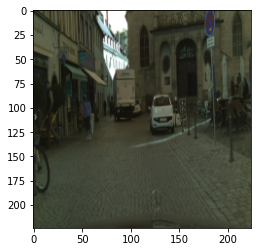

In [19]:
plt.imshow(x.permute(0,2,3,1)[i].int())

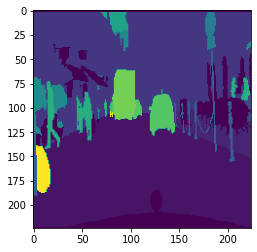

In [20]:
plt.imshow(y.permute(0,2,3,1)[i])

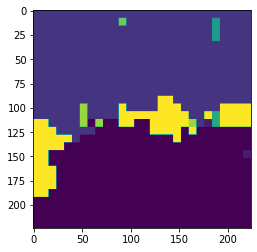

In [21]:
# seg
def resize_pred(pred, gt):
    return F.interpolate(pred, size=gt.shape[-2:])
pred = output
gt = y.cuda()
output = resize_pred(pred, gt)
prediction = torch.argmax(output, dim=1)
plt.imshow(prediction.cpu().detach().numpy()[i])

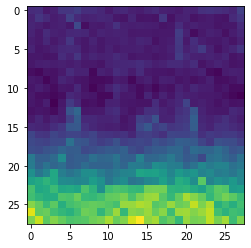

In [31]:
# depth
plt.imshow(output.cpu().detach().numpy()[i,0])

# Others

In [12]:
mtlmodel.net[0].taskOp.segment_semantic.weight

Parameter containing:
tensor([[[[ 1.9348e-01,  1.9046e-01,  1.7868e-01,  ...,  1.6289e-01,
            1.3305e-01,  1.4691e-01],
          [ 1.1127e-01,  1.8490e-02, -1.9056e-02,  ...,  1.0792e-01,
            7.5129e-02,  2.6224e-02],
          [ 5.9161e-02,  1.2628e-01,  4.1456e-02,  ...,  4.8540e-02,
           -5.2689e-02, -2.5313e-02],
          ...,
          [-1.7076e-01, -1.6649e-01, -5.4048e-02,  ..., -4.0136e-02,
           -1.8000e-01, -5.5735e-02],
          [-9.9670e-02, -1.1982e-01, -4.6479e-02,  ..., -2.8480e-02,
           -1.6647e-01, -4.2167e-02],
          [-1.4900e-02, -1.7457e-01, -1.2356e-01,  ..., -1.2068e-01,
           -1.8828e-01, -1.7409e-01]],

         [[ 3.9546e-01,  2.6007e-01,  3.0369e-01,  ...,  3.1506e-01,
            2.8149e-01,  3.6778e-01],
          [ 2.1045e-01,  1.4817e-01,  1.9734e-01,  ...,  2.0418e-01,
            2.5394e-01,  2.3090e-01],
          [ 2.2047e-01,  7.8727e-02,  2.1716e-01,  ...,  2.0573e-01,
            2.2162e-01,  1.1520e-01]

In [13]:
mtlmodel.net[0].taskOp.depth_zbuffer.weight

Parameter containing:
tensor([[[[-1.8881e-03,  1.8505e-02,  4.4373e-02,  ..., -1.2325e-02,
           -4.9379e-02, -4.5097e-02],
          [ 9.0981e-02,  4.1538e-02,  2.7948e-02,  ...,  1.1081e-01,
            5.2511e-02, -2.9954e-02],
          [ 8.2137e-02,  1.5644e-01,  7.6825e-02,  ...,  5.3679e-02,
           -4.4415e-02, -1.1095e-02],
          ...,
          [ 7.3310e-03,  6.0403e-03,  1.1486e-01,  ...,  1.0638e-01,
           -2.8108e-02,  1.0947e-01],
          [ 4.7898e-02,  2.8627e-02,  1.0086e-01,  ...,  9.8602e-02,
           -4.2270e-02,  8.3925e-02],
          [ 1.5200e-01, -1.0719e-03,  4.9900e-02,  ...,  3.8274e-02,
           -4.1196e-02, -3.8045e-02]],

         [[ 1.4453e-01,  2.7311e-02,  1.0204e-01,  ...,  4.7457e-02,
            3.2276e-03,  7.7583e-02],
          [ 7.5282e-02,  4.6295e-02,  1.1917e-01,  ...,  7.4346e-02,
            8.8846e-02,  3.4213e-02],
          [ 1.2747e-01,  6.2407e-04,  1.4398e-01,  ...,  8.4125e-02,
            9.4608e-02, -9.4846e-03]

In [10]:
print(mtlmodel)

MTLModel(
  (headsDict): ModuleDict(
    (segment_semantic): ASPPHeadNode(
      (fc1): Classification_Module(
        (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6))
        (conv2): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
        (conv3): Conv2d(1024, 19, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (fc2): Classification_Module(
        (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12))
        (conv2): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
        (conv3): Conv2d(1024, 19, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (fc3): Classification_Module(
        (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(18, 18), dilation=(18, 18))
        (conv2): Conv2d(1024, 1024, 